In [6]:
!mamba install famsa t-coffee mmseqs2 -y -q
!pip install -q protein-bert tensorflow==2.10.*

In [1]:
from learnMSA import msa_hmm

2023-08-14 14:06:09.969583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 14:06:10.056489: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-14 14:06:10.469291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/beckerf/mambaforge/envs/learnMSAdev/lib/:/lib:
2023-08-14 14:06:10.469508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: l

## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Training

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = msa_hmm.config.make_default(num_models)
alignment_model = msa_hmm.align.run_learnMSA(train_filename,
                                              out_filename,
                                              config, 
                                              sequence_weights=msa_hmm.align.compute_sequence_weights(train_filename, "tmp") if use_weights else None,
                                              verbose=True,
                                              align_insertions=align_insertions)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

2023-08-14 14:07:17.680926: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x560aebf6f6c0
2023-08-14 14:07:18.053646: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x560b096d7b00


10/10 - 44s - loss: 128.4771 - loglik: -9.7034e+01 - logprior: -3.1443e+01 - 44s/epoch - 4s/step
Epoch 2/10
10/10 - 1s - loss: 93.4778 - loglik: -8.4299e+01 - logprior: -9.1787e+00 - 1s/epoch - 103ms/step
Epoch 3/10
10/10 - 1s - loss: 79.4531 - loglik: -7.4584e+01 - logprior: -4.8695e+00 - 938ms/epoch - 94ms/step
Epoch 4/10
10/10 - 1s - loss: 73.1320 - loglik: -6.9735e+01 - logprior: -3.3967e+00 - 949ms/epoch - 95ms/step
Epoch 5/10
10/10 - 1s - loss: 70.4522 - loglik: -6.7737e+01 - logprior: -2.7156e+00 - 942ms/epoch - 94ms/step
Epoch 6/10
10/10 - 1s - loss: 69.3480 - loglik: -6.6976e+01 - logprior: -2.3715e+00 - 910ms/epoch - 91ms/step
Epoch 7/10
10/10 - 1s - loss: 68.8641 - loglik: -6.6681e+01 - logprior: -2.1831e+00 - 933ms/epoch - 93ms/step
Epoch 8/10
10/10 - 1s - loss: 68.6172 - loglik: -6.6588e+01 - logprior: -2.0290e+00 - 900ms/epoch - 90ms/step
Epoch 9/10
10/10 - 1s - loss: 68.5669 - loglik: -6.6647e+01 - logprior: -1.9202e+00 - 979ms/epoch - 98ms/step
Epoch 10/10
10/10 - 1s - 

2023-08-14 14:10:28.899288: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Long insertions found at ins_0_16: 10.
Long insertions found at right_flank: 4.


FAMSA (Fast and Accurate Multiple Sequence Alignment) 
  version 2.2.2- (2022-10-09)
  S. Deorowicz, A. Debudaj-Grabysz, A. Gudys

Done!
FAMSA (Fast and Accurate Multiple Sequence Alignment) 
  version 2.2.2- (2022-10-09)
  S. Deorowicz, A. Debudaj-Grabysz, A. Gudys

Done!


time for generating output: 1.6028
Wrote file test/data/interactive.alignment.fasta


8/8 [==============================] - 10s 23ms/step
>l=-54.69_t=0.01
............$C.D.......P........N............P........CYN.HG..T..C...S.......L......RA...T......................G......YTCSCL....PR......YT....GEH$.......................
>l=-57.14_t=0.01
............$C.D.......S........Q............P........CRN.-G..T..C...Sl......N......TN...T......................D......YTCACF....PG......YT....GRY$.......................
>l=-50.07_t=0.01
............$C.D.......S........D............P........CLN.GG..T..C...T.......L......RSl..D......................S......YSCACA....PG......YT....GQH$.......................
>l=-63.30_t=0.01
............$C.D.......H........V............T........CLN.GG..T..C...Q.......Lk.....TL...E......................D......YTCACA....NG......YT....GER$.......................
>l=-63.94_t=0.01
............$C.D.......H........V............T........CLN.GG..T..C...Q.......Lk.....TL...E......................E......YTCACA....NG......YT....GDR$.......................
>l=-64.

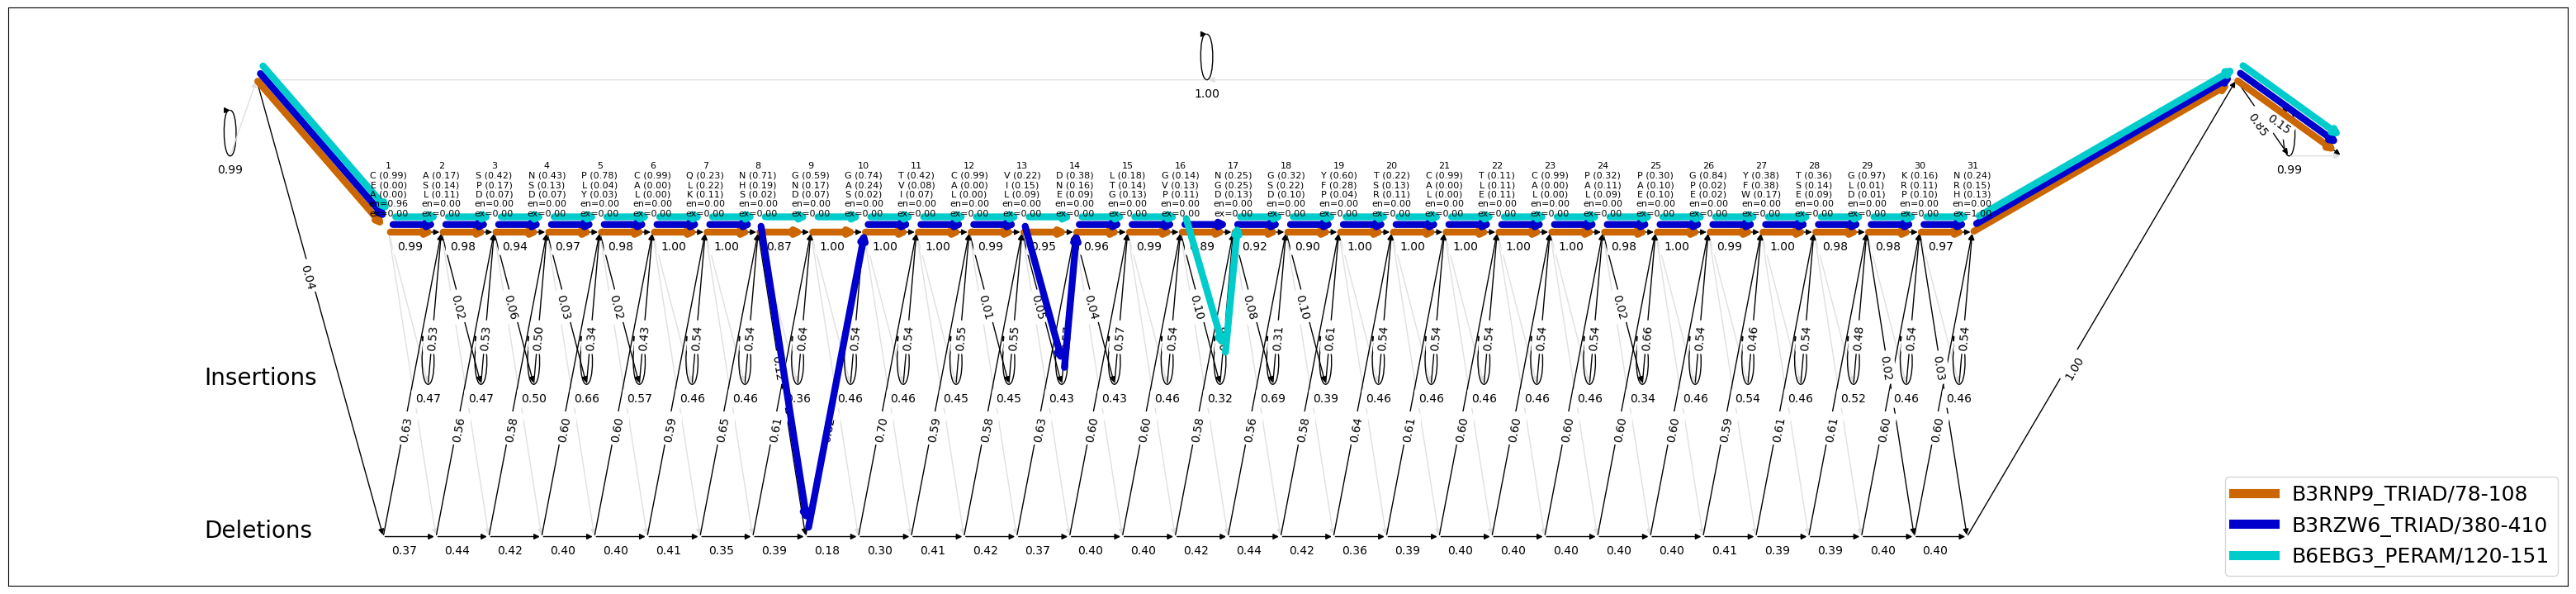

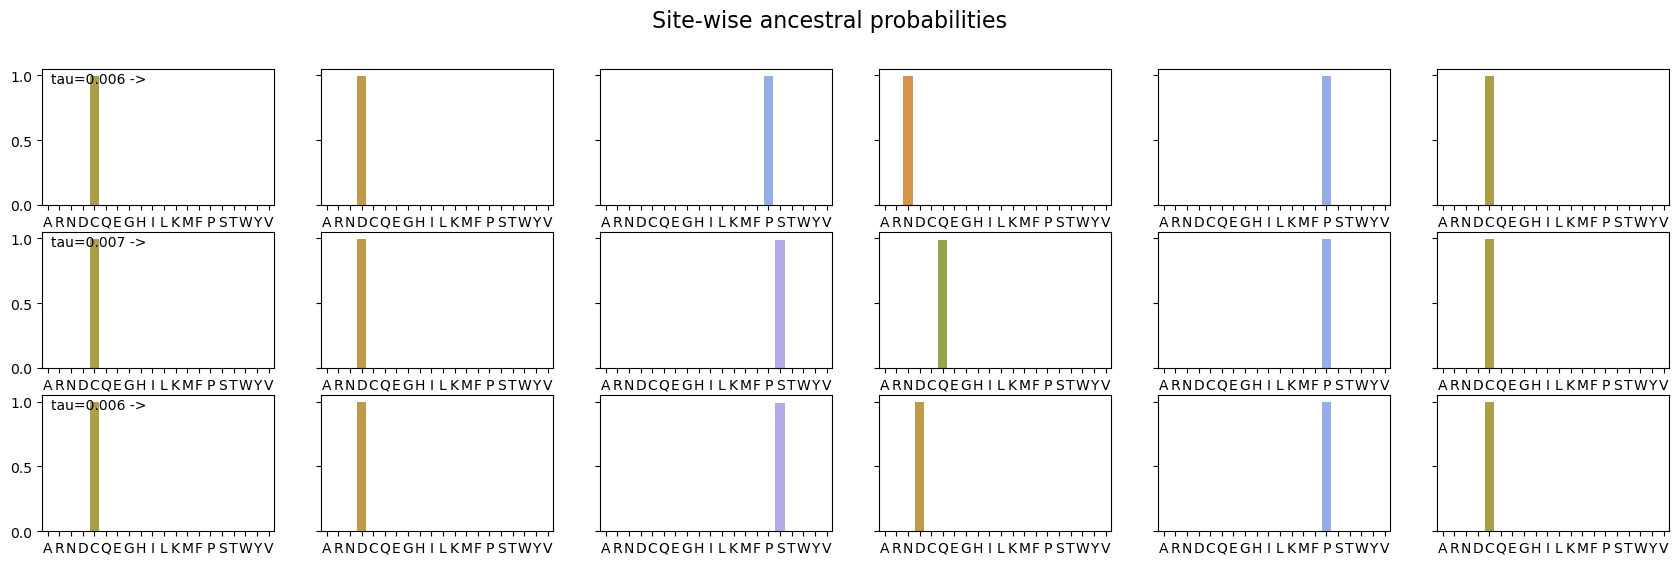

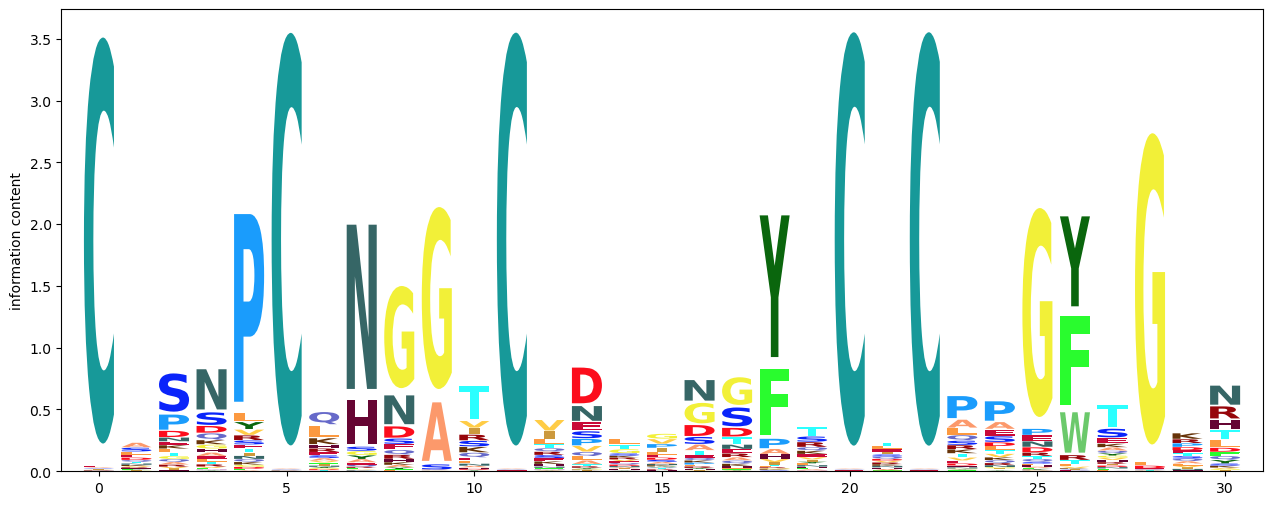

In [4]:
msa_hmm.vis.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    77.1 [100.0]   [ 5182]
